# 6章 学習に関するテクニック

## 6.1 パラメータの更新
ニューラルネットワークの学習の目的は損失関数の値をできるだけ小さくするパラメータを見つけることである。このような問題を解くことを「最適化(optimization)」という。
これまで確率的勾配降下法(SGD)で解いてきたが、問題によってはSGDより優れる最適化手法が存在する。

### 6.1.1 冒険家の話
割愛

### 6.1.2 SGD
SGDの復習。SGDは以下式で表せる。
$W ← W-\eta\frac{\partial L}{\partial W}$


In [2]:
class SGD:
    def __init__(self, lr=0.01):
        self.lr = lr
        
    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key]

### 6.1.3 SGDの欠点

SGDは問題によっては非効率な場合がある。以下関数の最小値を求める問題を考える。

$$f(x,y) = \frac{1}{20}x^{2} + y^{2}$$

上記式の場合y軸方向は勾配が大きいが、x軸方向は小さい。本来最小値は(0,0)の点であるが、勾配の矢印はそちらを向いていない。そのためSGDで最適化を行った場合y軸方向のジグザグばかりでなかなかx軸方向の探索が進まない欠点がある。


/Users/smap3/PycharmProjects/exercise_of_deep_larning_from_scratch/env/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "
/Users/smap3/PycharmProjects/exercise_of_deep_larning_from_scratch/env/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


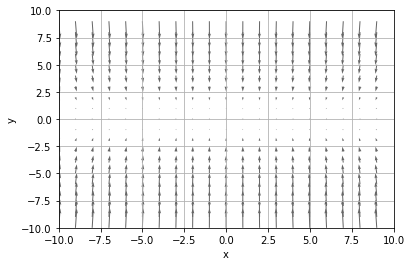

In [14]:
# cf.http://d.hatena.ne.jp/white_wheels/20100327/p3
import numpy as np
import matplotlib.pylab as plt
from mpl_toolkits.mplot3d import Axes3D


def _numerical_gradient_no_batch(f, x, axis='x'):
    h = 1e-4 # 0.0001
    grad = np.zeros_like(x)
    
    for idx in range(x.size):
        tmp_val = x[idx]
        x[idx] = float(tmp_val) + h
        fxh1 = f(x, axis) # f(x+h)

        x[idx] = tmp_val - h 
        fxh2 = f(x, axis) # f(x-h)
        grad[idx] = (fxh1 - fxh2) / (2*h)
        
        x[idx] = tmp_val # 値を元に戻す
        
    return grad


def numerical_gradient(f, X):
    if X.ndim == 1:
        return _numerical_gradient_no_batch(f, X)
    else:
        grad = np.zeros_like(X)
        
        for idx, x in enumerate(X):
            if(idx == 0):
                grad[idx] = _numerical_gradient_no_batch(f, x, axis='x')               
            elif(idx == 1):
                grad[idx] = _numerical_gradient_no_batch(f, x, axis='y')
        
        return grad


def function_2(x, axis='x'):
    if(axis == 'x'):
        return np.sum(x**2 / 20)
    elif(axis == 'y'):
        return np.sum(x**2)
  
     
if __name__ == '__main__':
    x = np.arange(-10, 10, 1)
    y = np.arange(-10, 10, 1)
    X, Y = np.meshgrid(x, y)
    
    X = X.flatten()
    Y = Y.flatten()
    
    grad = numerical_gradient(function_2, np.array([X, Y]) )
    
    plt.figure()
    plt.quiver(X, Y, -grad[0], -grad[1],  angles="xy",color="#666666")#,headwidth=10,scale=40,color="#444444")
    plt.xlim([-10, 10])
    plt.ylim([-10, 10])
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid()
    plt.legend()
    plt.draw()
    plt.show()

### 6.1.4 Momentum

モーメンタム(Momentum)という手法は以下式で表される。

$$
v ← \alpha v -\eta \frac{\partial L}{\partial W} \\
W ← W + v
$$

$W$:更新する重みパラメータ、$\frac{\partial L}{\partial W}$:Wに関する損失関数の勾配、$\eta$:学習係数、$v$:物理で言う速度である。
$\alpha v$では何も力を受けないときに徐々に減速するための役割を担う($\alpha$は0.9などを設定する)

お椀を転がるボールのように更新していく。これは同じ方向に力を受け続けたら加速し(x軸)、逆方向の力が加えられると減速する(y軸)イメージと類似している。


In [16]:
class Momentum:
    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
        
    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)
                
        for key in params.keys():
            self.v[key] = self.momentum*self.v[key] - self.lr*grads[key]
            params[key] += self.v[key]

### 6.1.5 AdaGrad

ニューラルネットワークの学習では学習係数が重要であり、小さすぎるとなかなか学習が進まず大きすぎると発散して学習ができない。

学習係数に関するテクニックで、「学習係数の減衰(learning rate decay)」という方法がある。学習が進むに連れて学習係数を小さくする手法である。パラメータ全体の学習係数の値を一括して下げる方法もあるが、AdaGradでは「1つ1つ」のパラメータに対して減衰を行なう。AdaGradの更新方法は以下である。

$$
h \gets h + \frac{\partial L}{\partial W} \odot \frac{\partial L}{\partial W}
$$

$$
W \gets W + \eta \frac{1}{\sqrt h} \frac{\partial L}{\partial W}
$$

$W$:更新する重みパラメータ、$\frac{\partial L}{\partial W}$:Wに関する損失関数の勾配、$\eta$:学習係数、$h$:これまでの勾配の2乗和($\odot$は行列の要素ごとの掛け算)。パラメータ更新の際に$\frac{1}{\sqrt h}$を乗算し学習のスケールを調整する。大きく更新された要素は学習係数が小さくなる。

AdaGradは過去の勾配を全て二乗和として記録するため進めるほど更新料が小さくなりつつける。そこでRMSPropという手法では過去のすべての勾配を均一に考えるのではなく、過去の勾配の影響は小さくし、直近の勾配情報を大きく影響を与えるようにする。(指数移動平均)

AdaGradの実装は以下となる。


In [ ]:
class AdaGrad:
    def __init__(self, lr=0.01):
        self.lr = lr
        self.h = None
        
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
            
        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)

### 6.1.6 Adam

お椀に転がるボールのような更新を行なうMomentumと、パラメータの要素ごとに更新料の減衰を行なうAdaGradを組み合わせた手法がAdamである。効率的にパラメータ空間を探索でき、ハイパーパラメータの「バイアス補正(偏りの補正)」が行われる。

Adamの実装は以下。
Adamは3つのハイパーパラメータを設定する。学習係数$\alpha$、一次モーメント用の係数$\beta_{1}$、二次モーメント用係数$\beta_{2}$。論文では$\beta_{1}$=0.9、$\beta_{2}$=0.999で多くの場合で上手くいくと述べられている。


In [ ]:
class Adam:

    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None
        
    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = {}, {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)
        
        self.iter += 1
        lr_t  = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)         
        
        for key in params.keys():
            #self.m[key] = self.beta1*self.m[key] + (1-self.beta1)*grads[key]
            #self.v[key] = self.beta2*self.v[key] + (1-self.beta2)*(grads[key]**2)
            self.m[key] += (1 - self.beta1) * (grads[key] - self.m[key])
            self.v[key] += (1 - self.beta2) * (grads[key]**2 - self.v[key])
            
            params[key] -= lr_t * self.m[key] / (np.sqrt(self.v[key]) + 1e-7)
            
            #unbias_m += (1 - self.beta1) * (grads[key] - self.m[key]) # correct bias
            #unbisa_b += (1 - self.beta2) * (grads[key]*grads[key] - self.v[key]) # correct bias
            #params[key] += self.lr * unbias_m / (np.sqrt(unbisa_b) + 1e-7)

### 6.1.7 どの更新手法を用いるか？



/Users/smap3/PycharmProjects/exercise_of_deep_larning_from_scratch/env/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


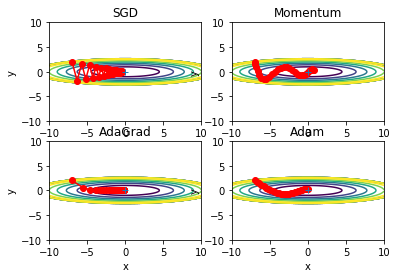

In [17]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
from src.optimizer import *


def f(x, y):
    return x**2 / 20.0 + y**2


def df(x, y):
    return x / 10.0, 2.0*y

init_pos = (-7.0, 2.0)
params = {}
params['x'], params['y'] = init_pos[0], init_pos[1]
grads = {}
grads['x'], grads['y'] = 0, 0


optimizers = OrderedDict()
optimizers["SGD"] = SGD(lr=0.95)
optimizers["Momentum"] = Momentum(lr=0.1)
optimizers["AdaGrad"] = AdaGrad(lr=1.5)
optimizers["Adam"] = Adam(lr=0.3)

idx = 1

for key in optimizers:
    optimizer = optimizers[key]
    x_history = []
    y_history = []
    params['x'], params['y'] = init_pos[0], init_pos[1]
    
    for i in range(30):
        x_history.append(params['x'])
        y_history.append(params['y'])
        
        grads['x'], grads['y'] = df(params['x'], params['y'])
        optimizer.update(params, grads)
    

    x = np.arange(-10, 10, 0.01)
    y = np.arange(-5, 5, 0.01)
    
    X, Y = np.meshgrid(x, y) 
    Z = f(X, Y)
    
    # for simple contour line  
    mask = Z > 7
    Z[mask] = 0
    
    # plot 
    plt.subplot(2, 2, idx)
    idx += 1
    plt.plot(x_history, y_history, 'o-', color="red")
    plt.contour(X, Y, Z)
    plt.ylim(-10, 10)
    plt.xlim(-10, 10)
    plt.plot(0, 0, '+')
    #colorbar()
    #spring()
    plt.title(key)
    plt.xlabel("x")
    plt.ylabel("y")
    
plt.show()

上記ではAdaGradが一番良く見えるが、扱う問題やハイパーパラメータ(学習係数など)の設定値によって結果が変わる。


### 6.1.8 MNISTデータセットによる更新手法の比較

MNISTを対象に4つの更新手法の比較を行なう。


===========iteration:0===========
SGD:2.36521284066
Momentum:2.34537275011
AdaGrad:2.22104501819
Adam:2.1870800864


===========iteration:100===========
SGD:1.48456273248
Momentum:0.325060598643
AdaGrad:0.153036624764
Adam:0.230585299337


===========iteration:200===========
SGD:0.727890606891
Momentum:0.235794270445
AdaGrad:0.11509169707
Adam:0.133266722382


===========iteration:300===========
SGD:0.615651583762
Momentum:0.187522430865
AdaGrad:0.0799886188244
Adam:0.145038274825


===========iteration:400===========
SGD:0.540487484719
Momentum:0.180059194963
AdaGrad:0.0675677976226
Adam:0.112541213809


===========iteration:500===========
SGD:0.469815795511
Momentum:0.205706184277
AdaGrad:0.0600932342145
Adam:0.123140541932


===========iteration:600===========
SGD:0.384826232556
Momentum:0.179244024102
AdaGrad:0.0490103374775
Adam:0.0866054169778


===========iteration:700===========
SGD:0.284851076143
Momentum:0.0581067070481
AdaGrad:0.0332084196503
Adam:0.0608779112661


===========iteration:800===========
SGD:0.335301673071
Momentum:0.113315597088
AdaGrad:0.0562280389978
Adam:0.0781103462844


===========iteration:900===========
SGD:0.35814911006
Momentum:0.108310176042
AdaGrad:0.08824054641
Adam:0.103355176959


===========iteration:1000===========
SGD:0.234264295064
Momentum:0.0986747502045
AdaGrad:0.0506454540046
Adam:0.0894517341021


===========iteration:1100===========
SGD:0.264615815257
Momentum:0.0691690508017
AdaGrad:0.0429805078074
Adam:0.0537260606211


===========iteration:1200===========
SGD:0.206429122532
Momentum:0.0433315275413
AdaGrad:0.0246323026696
Adam:0.0234086119077


===========iteration:1300===========
SGD:0.286266254622
Momentum:0.119290090896
AdaGrad:0.0424446099291
Adam:0.0574741716302


===========iteration:1400===========
SGD:0.173681762073
Momentum:0.0572317935526
AdaGrad:0.0256051356087
Adam:0.0480660235138


===========iteration:1500===========
SGD:0.267637289665
Momentum:0.106020602567
AdaGrad:0.0372252004695
Adam:0.0676614907455


===========iteration:1600===========
SGD:0.221664804705
Momentum:0.199423462474
AdaGrad:0.104168998471
Adam:0.134287257037


===========iteration:1700===========
SGD:0.167431437261
Momentum:0.059685292398
AdaGrad:0.0259113005557
Adam:0.0267586883567


===========iteration:1800===========
SGD:0.0970496993112
Momentum:0.0193055767589
AdaGrad:0.0224675793566
Adam:0.0155859956683


===========iteration:1900===========
SGD:0.168337577376
Momentum:0.0307487485122
AdaGrad:0.0207297490481
Adam:0.024736231273


/Users/smap3/PycharmProjects/exercise_of_deep_larning_from_scratch/env/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


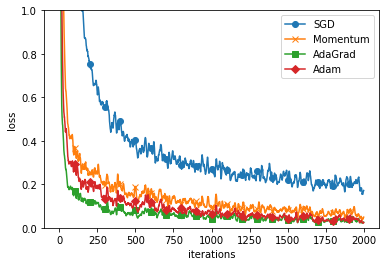

In [22]:
import os
import sys
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import matplotlib.pyplot as plt
from src.mnist import load_mnist
from src.util import smooth_curve
from src.multi_layer_net import MultiLayerNet
from src.optimizer import *


# 0:MNISTデータの読み込み==========
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000


# 1:実験の設定==========
optimizers = {}
optimizers['SGD'] = SGD()
optimizers['Momentum'] = Momentum()
optimizers['AdaGrad'] = AdaGrad()
optimizers['Adam'] = Adam()
#optimizers['RMSprop'] = RMSprop()

networks = {}
train_loss = {}
for key in optimizers.keys():
    networks[key] = MultiLayerNet(
        input_size=784, hidden_size_list=[100, 100, 100, 100],
        output_size=10)
    train_loss[key] = []    


# 2:訓練の開始==========
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in optimizers.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizers[key].update(networks[key].params, grads)
    
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
    
    if i % 100 == 0:
        print( "===========" + "iteration:" + str(i) + "===========")
        for key in optimizers.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))


# 3.グラフの描画==========
markers = {"SGD": "o", "Momentum": "x", "AdaGrad": "s", "Adam": "D"}
x = np.arange(max_iterations)
for key in optimizers.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 1)
plt.legend()
plt.show()

SGD以外の手法が早く学習できている。AdaGradが最も早く学習出来ているように見える。一般にSGDよりほかの3つの手法のほうが早く学習でき、時には最終的な認識性能も高くなる。



## 6.2 重みの初期値

ニューラルネットワークでは重みの初期値も重要である。


### 6.2.1 重みの初期値を0にする？

科学集を抑えて汎化性能を高める手法として「Weight decay(荷重減衰)」がある。この手法は重みパラメータの値が小さくなるように学習を行なうことを目的としている。(過学習を起きにくくする)

初期値を小さい状態からスタートするのが正攻法である(これまでもガウス分布から生成される値を0.01倍した値などを利用してきた)が、全て0に設定するのは不適当である。

全てを0(正確には重みを均一な値に設定)にすると、誤差逆伝播法において全ての重みの値が均一に更新されてしまうため。1層目も2層目も同じように重みは対象的な値を持つようになってしまい、上手く学習できない。

重みが均一になる(対象的な構造になる)ことを防ぐには、ランダムな初期値が必要。



### 6.2.2 隠れ層のアクティベーション分布

隠れ層のアクティベーション(活性化関数の後の出力データ)の分布を観察することから多くの知見が得られる。重みの初期値によって隠れ層のアクティベーションがどのように変化するか確認する。

5層のニューラルネットワークで活性化関数にシグモイド関数を使用する。ランダムに生成した入力データから角層のアクティベーションのデータ分布をヒストグラムで描画する。


/Users/smap3/PycharmProjects/exercise_of_deep_larning_from_scratch/env/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


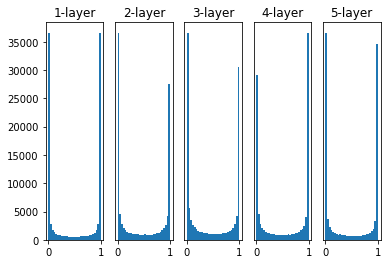

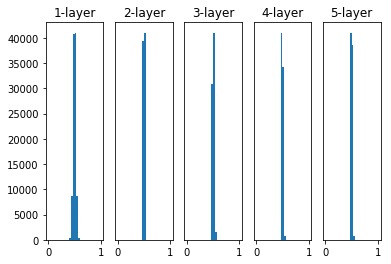

In [4]:
import numpy as np
import matplotlib.pyplot as plt


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def ReLU(x):
    return np.maximum(0, x)


def tanh(x):
    return np.tanh(x)
    
input_data = np.random.randn(1000, 100)  # 1000個のデータ
node_num = 100  # 各隠れ層のノード（ニューロン）の数
hidden_layer_size = 5  # 隠れ層が5層
activations = {}  # ここにアクティベーションの結果を格納する
activations01 = {}  # ここにアクティベーションの結果を格納する
activationsxa = {}  # ここにアクティベーションの結果を格納する

x = input_data
x01 = input_data
xxa = input_data

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]
        x01 = activations01[i-1]
        xxa = activationsxa[i-1]

    # 初期値の値をいろいろ変えて実験しよう！
    w = np.random.randn(node_num, node_num) * 1
    w01 = np.random.randn(node_num, node_num) * 0.01
    wxa = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num)
    # w = np.random.randn(node_num, node_num) * np.sqrt(2.0 / node_num)


    a = np.dot(x, w)
    a01 = np.dot(x01, w01)
    axa = np.dot(xxa, wxa)


    # 活性化関数の種類も変えて実験しよう！
    z = sigmoid(a)
    z01 = sigmoid(a01)
    zxa = sigmoid(axa)

    # z = ReLU(a)
    # z = tanh(a)

    activations[i] = z
    activations01[i] = z01
    activationsxa[i] = zxa

# ヒストグラムを描画(標準偏差1)
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    # plt.xlim(0.1, 1)
    # plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()


# ヒストグラムを描画(標準偏差0.1)
for i, a in activations01.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    # plt.xlim(0.1, 1)
    # plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

上記の上表を見ると、標準偏差1のガウス分布で与えられた重みの初期値において各層のアクティベーションは0や1に偏っている。
活性化関数であるシグモイド関数は出力が0や1に近づくほど微分は0に近づくため、逆伝播の際には勾配の値がどんどん小さくなって消えてしまう。これを「勾配消失問題(gradient vanishing)」と呼び、層が深くなるほど深刻になってくる。

上記の下表である標準偏差0.1のガウス分布で与えられた重みの初期値では0.5付近に集中している。この場合、勾配消失の問題は発生しないが表現力に大きな問題がある。複数のニューロンが同じ値を出力すれば、いわば1個のニューロンでも同じ結果であるため表現力が乏しいと言える。

これらのことから各層のアクティベーションの分布は適度な広がりを持つことが求められることが分かる。

次にディープラーニングのフレームワークで標準的に利用されている「Xavierの初期値」(Xavier Glorotの論文で推奨される重みの初期値)で確認してみる。

この論文では角層のアクティベーションを同じ広がりのある分布にすることを目的として、適切な重みのスケールを導いた。前層のノードの個数を$n$とした場合、$\frac{1}{\sqrt n}$の標準偏差を持つガウス分布を使うと良い。これは前層のノードの数が多ければ多いほど初期値として設定する重みは小さくなることとなる。

確認結果は以下となる。上位層につれていびつになるが、広がりを持った分布となっている。これによりシグモイド関数でも表現力を損なわずに効率的に学習が出来る。

いびつである点については活性化関数に$tanh$(双曲線関数)を用いれば改善される。tanhが原点で対象なカーブであるためである。一般的に活性化関数は減点対象であることが望ましい性質として知られる。



/Users/smap3/PycharmProjects/exercise_of_deep_larning_from_scratch/env/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


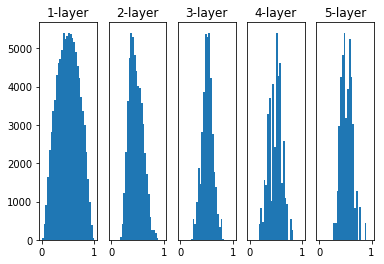

In [31]:
# ヒストグラムを描画(標準偏差 Xavier)
for i, a in activationsxa.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    # plt.xlim(0.1, 1)
    # plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

### 6.2.3 ReLUの場合の重みの初期値

Xavierの初期値は活性化関数が線形である場合を前提としている。ReLUを用いる場合は特化した初期値を用いることが推奨される。Kaiming Heが推奨する初期値である「Heの初期値」がある。

Heの初期値では前層ノードの数がn個の場合、$\sqrt \frac{2}{n}$を標準偏差とするガウス分布を用いる。Xavierの初期値が$\sqrt \frac{1}{n}$であったことを考えるとReLUは負の領域が0になっているため係数を倍にすることで広がりを表現しようとしていると直感的には解釈できる。


/Users/smap3/PycharmProjects/exercise_of_deep_larning_from_scratch/env/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


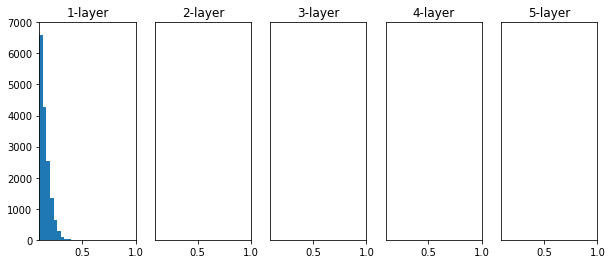

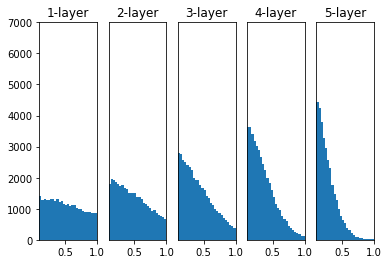

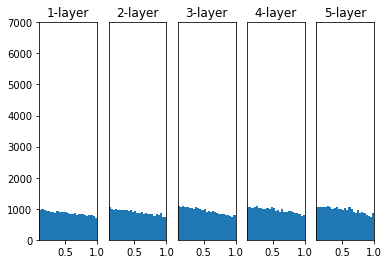

In [23]:
import numpy as np
import matplotlib.pyplot as plt

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def ReLU(x):
    return np.maximum(0, x)

def tanh(x):
    return np.tanh(x)
    
input_data = np.random.randn(1000, 100)  # 1000個のデータ
node_num = 100  # 各隠れ層のノード（ニューロン）の数
hidden_layer_size = 5  # 隠れ層が5層

activations001 = {}  # ここにアクティベーションの結果を格納する
activationsxa = {}  # ここにアクティベーションの結果を格納する
activationshe = {}  # ここにアクティベーションの結果を格納する

x001 = input_data
xxa = input_data
xhe = input_data

for i in range(hidden_layer_size):
    if i != 0:
        x001 = activations001[i-1]
        xxa = activationsxa[i-1]
        xhe = activationshe[i-1]

    # 初期値の値をいろいろ変えて実験しよう！
    w001 = np.random.randn(node_num, node_num) * 0.01
    wxa = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num)
    whe = np.random.randn(node_num, node_num) * np.sqrt(2.0 / node_num)

    a001 = np.dot(x001, w001)
    axa = np.dot(xxa, wxa)
    ahe = np.dot(xhe, whe)

    z001 = ReLU(a001)
    zxa = ReLU(axa)
    zhe = ReLU(ahe)

    activations001[i] = z001
    activationsxa[i] = zxa
    activationshe[i] = zhe

# ヒストグラムを描画(標準偏差0.01)
for i, a in activations001.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    plt.xlim(0.1, 1)
    plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()


# ヒストグラムを描画(Xavier)
for i, a in activationsxa.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    plt.xlim(0.1, 1)
    plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

# ヒストグラムを描画(He)
for i, a in activationshe.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    plt.xlim(0.1, 1)
    plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

「std=0.01」の場合いずれの層でもアクティベーションは小さくなるため、逆伝播の際の勾配も小さくなる。「Xavierの初期値」の場合層が深くなるにつれて偏りが少しづつ大きくなる。これより層を深くすればアクティベーションの方よりも大きくなり、学習の際に勾配消失問題が発生してしまう。「Heの初期値」においては均一の広がりであることが見て取れる。逆伝播の際にもよい結果が得られる。

よって活性化関数にReLUを用いるときには「Heの初期値」、sigmoidやtanhを用いる時は「Xavierの初期値」を用いるのが良い。





### 6.2.4 MNISTデータセットによる重みの初期値の比較

実際のデータであるMNISTについて重みの初期値による学習の影響を確認する。確認するのは「std=0.01」、「Xavierの初期値」、「Heの初期値」の3パターンで行なう。

ここでは5層のニューラルネットワークであり、各層は100個のニューロンを持つ。活性化関数はReLUである。

===========iteration:0===========
std=0.01:2.30254515513
Xavier:2.31252369437
He:2.40095806492


===========iteration:100===========
std=0.01:2.30171402646
Xavier:2.26680956615
He:1.69296317249


===========iteration:200===========
std=0.01:2.30186348219
Xavier:2.17458527818
He:0.961528088049


===========iteration:300===========
std=0.01:2.30191736728
Xavier:1.97454777614
He:0.633550263043


===========iteration:400===========
std=0.01:2.30201187216
Xavier:1.60646819053
He:0.427884515743


===========iteration:500===========
std=0.01:2.30367169578
Xavier:1.11885104617
He:0.415772591537


===========iteration:600===========
std=0.01:2.30038665424
Xavier:0.77272298891
He:0.331801058411


===========iteration:700===========
std=0.01:2.30015580745
Xavier:0.563742270269
He:0.317685791565


===========iteration:800===========
std=0.01:2.29821215976
Xavier:0.437755756476
He:0.324046516949


===========iteration:900===========
std=0.01:2.30453391826
Xavier:0.517981929242
He:0.391583254917


===========iteration:1000===========
std=0.01:2.30505929488
Xavier:0.36373828278
He:0.228018894773


===========iteration:1100===========
std=0.01:2.30738058349
Xavier:0.538536578681
He:0.35581891004


===========iteration:1200===========
std=0.01:2.29712276727
Xavier:0.336008970039
He:0.272937759814


===========iteration:1300===========
std=0.01:2.30536246665
Xavier:0.342566509665
He:0.289917117669


===========iteration:1400===========
std=0.01:2.29814488588
Xavier:0.33038214479
He:0.303689455278


===========iteration:1500===========
std=0.01:2.29834816988
Xavier:0.384987132243
He:0.34679693761


===========iteration:1600===========
std=0.01:2.30111756282
Xavier:0.360697326334
He:0.290414671463


===========iteration:1700===========
std=0.01:2.30282052105
Xavier:0.424561912736
He:0.327131822825


===========iteration:1800===========
std=0.01:2.30286573074
Xavier:0.250563774168
He:0.224442894047


===========iteration:1900===========
std=0.01:2.29816644537
Xavier:0.333324565303
He:0.228027046788


/Users/smap3/PycharmProjects/exercise_of_deep_larning_from_scratch/env/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


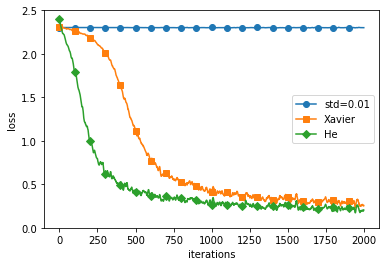

In [14]:
import os
import sys

sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
import matplotlib.pyplot as plt
from src.mnist import load_mnist
from src.util import smooth_curve
from src.multi_layer_net import MultiLayerNet
from src.optimizer import SGD


# 0:MNISTデータの読み込み==========
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000


# 1:実験の設定==========
weight_init_types = {'std=0.01': 0.01, 'Xavier': 'sigmoid', 'He': 'relu'}
optimizer = SGD(lr=0.01)

networks = {}
train_loss = {}
for key, weight_type in weight_init_types.items():
    networks[key] = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100],
                                  output_size=10, weight_init_std=weight_type)
    train_loss[key] = []


# 2:訓練の開始==========
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in weight_init_types.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizer.update(networks[key].params, grads)
    
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
    
    if i % 100 == 0:
        print("===========" + "iteration:" + str(i) + "===========")
        for key in weight_init_types.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))


# 3.グラフの描画==========
markers = {'std=0.01': 'o', 'Xavier': 's', 'He': 'D'}
x = np.arange(max_iterations)
for key in weight_init_types.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 2.5)
plt.legend()
plt.show()

「std=0.01」ではほとんど学習が進んでいない。アクティベーションが0に偏っており、勾配が殆どないため重みの更新がほとんど行われていないためと考えられる。

「Xavierの初期値」「Heの初期値」においては学習が上手く進んでおり、後者のほうが学習の進みが早いことが分かる。

これらのことから重みの初期値は学習において重要であることが分かる。


## 6.3 Batch Normalization

重みの初期値では各層のアクティベーションの分布を確認したが、各層で適度な広がりを持つように強制的に分布を調整するのがBatch Normalizationである。

### 6.3.1 Batch Normalization のアルゴリズム

Batch Normには次の利点がある。

* 学習を早く進行させることが出来る(学習係数を大きくすることができる)
* 初期値にそれほど依存しない(神経質にならなくて良い)
* 過学習を抑制する(Dropoutなどの必要性を減らす)

Batch Normは学習を行う際のミニバッチを単位として正規化を行なう。具体的にはデータ分布の平均が0で分散が1になるようにする。数式は以下となる。

$$
\mu_{B} \gets \frac{1}{m} \sum_{i=1}^{m} x_{i} \\
\sigma_{B}^{2} \gets \frac{1}{m} \sum_{i=1}^{m} (x_{i}-\mu_{B})^2 \\
\hat{x}_{i} \gets \frac{x_{i}-\mu_{B}}{\sqrt{\sigma_{B}^{2}+\epsilon}}
$$

ミニバッチ:$B=\{x_{1},x_{2},・・・,x_{m}\}$  
平均:$\mu_{B}$  
分散:$\sigma_{B}^{2}$  

$\epsilon$は小さな値(10e-7)などであり、0で除算することを防ぐために加えるものである。
上記式はミニバッチの入力データ$\{x_{1},x_{2},・・・,x_{m}\}$を平均0、分散1のデータ$\{\hat{x}_{1},\hat{x}_{2},・・・,\hat{x}_{m}\}$に変換している。

正規化の処理は活性化関数の前もしくは後ろに挿入する。(どちらが良いかは議論の余地あり)
Batch Normレイヤではこの正規化されたデータに対して固有のスケールとシフトで変換する。

$$
y_{i} = \gamma \hat{x}_{i} + \beta
$$

$\gamma$と$\beta$はパラメータであり、最初は$\gamma=1$,$\beta=0$からスタートして学習によって適した値に調整されていく。

これは順伝播の場合であるが、逆伝播の値もこちらから導出することが出来る。



### 6.3.2 Batch Normalizationの評価






../src/functions.py:55: RuntimeWarning: divide by zero encountered in log
  return -np.sum(np.log(y[np.arange(batch_size), t])) / batch_size
../src/functions.py:33: RuntimeWarning: invalid value encountered in subtract
  x = x - np.max(x, axis=0)
../src/layers.py:11: RuntimeWarning: invalid value encountered in less_equal
  self.mask = (x <= 0)


/Users/smap3/PycharmProjects/exercise_of_deep_larning_from_scratch/env/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


/Users/smap3/PycharmProjects/exercise_of_deep_larning_from_scratch/env/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


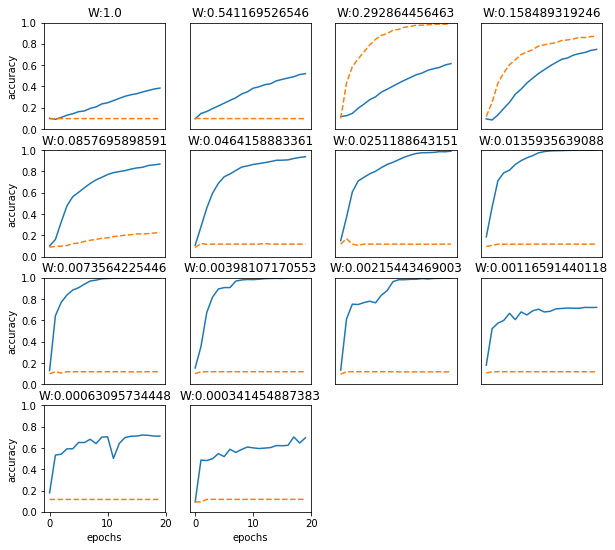

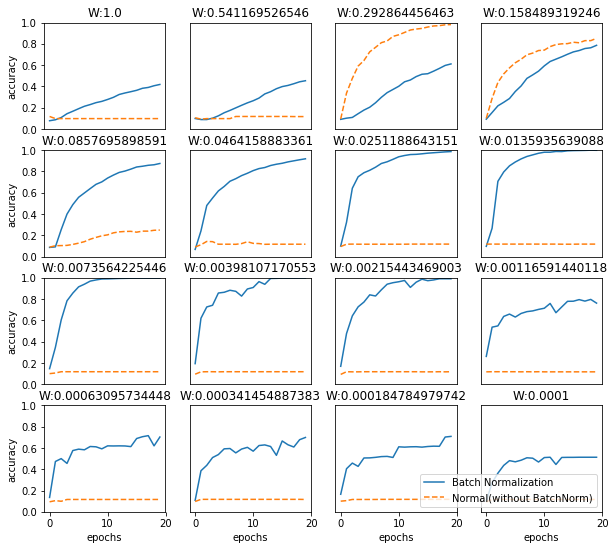

In [42]:
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
import matplotlib.pyplot as plt
from src.mnist import load_mnist
from src.multi_layer_net_extend import MultiLayerNetExtend
from src.optimizer import SGD, Adam

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 学習データを削減
x_train = x_train[:1000]
t_train = t_train[:1000]

max_epochs = 20
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.01


def __train(weight_init_std):
    bn_network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100], output_size=10, 
                                    weight_init_std=weight_init_std, use_batchnorm=True)
    network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100], output_size=10,
                                weight_init_std=weight_init_std)
    optimizer = SGD(lr=learning_rate)
    
    train_acc_list = []
    bn_train_acc_list = []
    
    iter_per_epoch = max(train_size / batch_size, 1)
    epoch_cnt = 0
    
    for i in range(1000000000):
        batch_mask = np.random.choice(train_size, batch_size)
        x_batch = x_train[batch_mask]
        t_batch = t_train[batch_mask]
    
        for _network in (bn_network, network):
            grads = _network.gradient(x_batch, t_batch)
            optimizer.update(_network.params, grads)
    
        if i % iter_per_epoch == 0:
            train_acc = network.accuracy(x_train, t_train)
            bn_train_acc = bn_network.accuracy(x_train, t_train)
            train_acc_list.append(train_acc)
            bn_train_acc_list.append(bn_train_acc)
    
#            print("epoch:" + str(epoch_cnt) + " | " + str(train_acc) + " - " + str(bn_train_acc))
    
            epoch_cnt += 1
            if epoch_cnt >= max_epochs:
                break
                
    return train_acc_list, bn_train_acc_list


# 3.グラフの描画==========
plt.figure(figsize=(10,9))

weight_scale_list = np.logspace(0, -4, num=16)
x = np.arange(max_epochs)

for i, w in enumerate(weight_scale_list):
#    print( "============== " + str(i+1) + "/16" + " ==============")
    train_acc_list, bn_train_acc_list = __train(w)
    
    plt.subplot(4,4,i+1)
    plt.title("W:" + str(w))
    if i == 15:
        plt.plot(x, bn_train_acc_list, label='Batch Normalization', markevery=2)
        plt.plot(x, train_acc_list, linestyle = "--", label='Normal(without BatchNorm)', markevery=2)
    else:
        plt.plot(x, bn_train_acc_list, markevery=2)
        plt.plot(x, train_acc_list, linestyle="--", markevery=2)

    plt.ylim(0, 1.0)
    if i % 4:
        plt.yticks([])
    else:
        plt.ylabel("accuracy")
    if i < 12:
        plt.xticks([])
    else:
        plt.xlabel("epochs")
    plt.legend(loc='lower right')


plt.show()

重みの初期値の標準偏差を変えたときの学習経過は上記になる。実践がBatch Normあり、破線がBatch Normなしである。多くのケースでBatch Normを利用したほうが学習が早く進んでいる。

このことからBatch Normを利用することで学習の進行を促進させることができ、重みの初期値にロバストになる(初期値に依存しなくなる)。


## 6.4 正規化

機械学習において過学習(over fitting)が問題になることが多々ある。訓練データにだけ適応しすぎ、他のデータを識別するための汎化性能を持たなくなることを言う。

### 6.4.1 過学習
過学習の原因としては以下2点が挙げられる。

* パラメータを大量に持ち、表現力が高いモデルであること
* 訓練データが少ないこと

意図的に過学習を発生させ確認する。MNISTデータセットにおける訓練データを60000個から300個に限定し、7層のネットワーク、各層のニューロンを100個、活性関数にReLUを用いて学習を行なう。





/Users/smap3/PycharmProjects/exercise_of_deep_larning_from_scratch/env/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


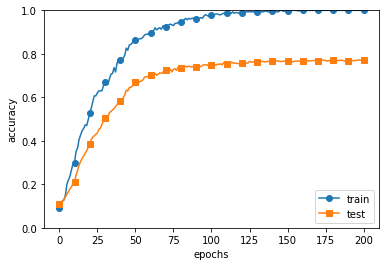

In [1]:
import os
import sys

sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
import matplotlib.pyplot as plt
from src.mnist import load_mnist
from src.multi_layer_net import MultiLayerNet
from src.optimizer import SGD

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 過学習を再現するために、学習データを削減
x_train = x_train[:300]
t_train = t_train[:300]

# weight decay（荷重減衰）の設定 =======================
weight_decay_lambda = 0 # weight decayを使用しない場合
# weight_decay_lambda = 0.1
# ====================================================

network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100], output_size=10,
                        weight_decay_lambda=weight_decay_lambda)
optimizer = SGD(lr=0.01)

max_epochs = 201
train_size = x_train.shape[0]
batch_size = 100

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)
epoch_cnt = 0

for i in range(1000000000):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    grads = network.gradient(x_batch, t_batch)
    optimizer.update(network.params, grads)

    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

#        print("epoch:" + str(epoch_cnt) + ", train acc:" + str(train_acc) + ", test acc:" + str(test_acc))

        epoch_cnt += 1
        if epoch_cnt >= max_epochs:
            break


# 3.グラフの描画==========
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

エポック(訓練データを全て見終わった単位)毎に、訓練データとテストデータの認識精度を確認した結果が上記となる。

訓練データにおいては100エポックを終えたあたりから認識精度が100%となっている。一方でテストデータにおいては80%未満であり精度が上がらなくなっている。訓練データにだけ適応していることから過学習していることが分かる。


### 4.6.2 Weight decay

過学習を防ぐために「Weight decay(荷重減衰)」という手法がある。学習の過程において大きな重みを持つことにペナルティを課す。過学習は重みパラメータが大きな値を取ることで発生することが多くあるためである。

損失関数に重みの2乗ノルム(L2ノルム)を損失関数に加算することでペナルティを与える。
具体的には全ての重みに対して$\frac{1}{2} \lambda W^{2}$を損失関数に加算する。誤差逆伝播において勾配を求める際には$\lambda W$が加算されることとなる。($\frac{1}{2}$は微分後の計算をしやすくするためにある)

/Users/smap3/PycharmProjects/exercise_of_deep_larning_from_scratch/env/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


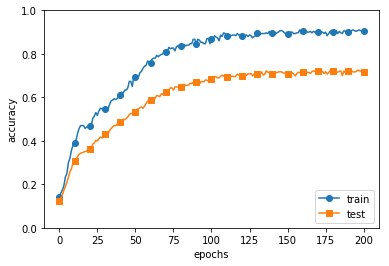

In [4]:
import os
import sys

sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
import matplotlib.pyplot as plt
from src.mnist import load_mnist
from src.multi_layer_net import MultiLayerNet
from src.optimizer import SGD

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 過学習を再現するために、学習データを削減
x_train = x_train[:300]
t_train = t_train[:300]

# weight decay（荷重減衰）の設定 =======================
# weight_decay_lambda = 0 # weight decayを使用しない場合
weight_decay_lambda = 0.1
# ====================================================

network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100], output_size=10,
                        weight_decay_lambda=weight_decay_lambda)
optimizer = SGD(lr=0.01)

max_epochs = 201
train_size = x_train.shape[0]
batch_size = 100

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)
epoch_cnt = 0

for i in range(1000000000):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    grads = network.gradient(x_batch, t_batch)
    optimizer.update(network.params, grads)

    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

#        print("epoch:" + str(epoch_cnt) + ", train acc:" + str(train_acc) + ", test acc:" + str(test_acc))

        epoch_cnt += 1
        if epoch_cnt >= max_epochs:
            break


# 3.グラフの描画==========
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

Weight decayを加えた結果、訓練データとテストデータ間の差は縮まった事が分かる。一方で訓練データの認識性能が下がったことも注目すべきである。

### 6.4.3 Dropout

ニューラルネットのモデルが複雑になるとWeight Decayだけでは過学習に対応できなくなる。そこで「Dropout」という手法を用いる。

Dropoutはニューロンをランダムに消去しながら学習する。訓練時に隠れ層のニューロンをランダムに選出し消去する。訓練の際にデータが流れる度に消去するニューロンを選出する。一方、テスト時には全てのニューロン信号を伝達するが、各ニューロンの出力に対して、訓練時に消去した割合を乗算して出力する。
訓練の際に適切な計算を行えば順伝播には単にデータを流すだけで消去した割合を乗算しなくてもよい。(ディープラーニングのフレームワークが参考になる)


/Users/smap3/PycharmProjects/exercise_of_deep_larning_from_scratch/env/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


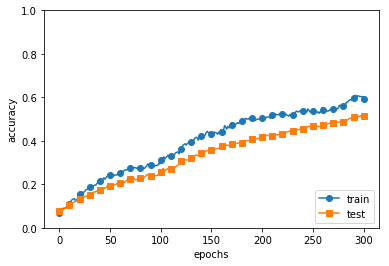

In [2]:
import os
import sys
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
import matplotlib.pyplot as plt
from src.mnist import load_mnist
from src.multi_layer_net_extend import MultiLayerNetExtend
from src.trainer import Trainer

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 過学習を再現するために、学習データを削減
x_train = x_train[:300]
t_train = t_train[:300]

# Dropuoutの有無、割り合いの設定 ========================
use_dropout = True  # Dropoutなしのときの場合はFalseに
dropout_ratio = 0.2
# ====================================================

network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100],
                              output_size=10, use_dropout=use_dropout, dropout_ration=dropout_ratio)


trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=301, mini_batch_size=100,
                  optimizer='sgd', optimizer_param={'lr': 0.01}, verbose=False)
trainer.train()

train_acc_list, test_acc_list = trainer.train_acc_list, trainer.test_acc_list

# グラフの描画==========
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

Dropout=0.2とした場合、上記結果となる。訓練データセットとテストデータセットの差が縮まってきており、上手く学習が行えている。このようにDropoutを行なうと表現力を保ったまま、過学習を抑制することが出来る。

Dropout実装のポイントとしては順伝播の度に消去するニューロンを選定するmaskを作成する。maskはニューロン毎に予め設定した確率でFalseを発生させ、入力データと掛け合わせることによって消去動作を実現する。逆伝播においてはReLUと同様に順伝播を通常通り行ったニューロンはそのまま、消去したニューロンは信号を止めるため0を掛け合わせる。


Dropoutはアンサンブル学習に類似している。アンサンブル学習では複数のモデルを個別に学習し、推論時に出力の平均を取ることで表現力を高くしているが、Dropoutはランダムにニューロンを消去することで様々なモデルを用いていると考えることが出来るためである。



## 6.5 ハイパーパラメータの検証

ニューラルネットワークでは「ハイパーパラメータ(hyper-parameter)」を定める必要がある。各層のニューロンの数やバッチサイズ、パラメータ更新の際の学習係数やWeight decayなどがある。

ハイパーパラメータの決定には多くの試行錯誤が必要だが、効率的に探索する方法がいくつが存在する。

### 6.5.1 検証データ

これまで訓練データで学習しテストデータで汎化性能を評価していたが、ハイパーパラメータの検証において、テストデータを用いて調整を行ってはいけない。もし利用した場合、ハイパーパラメータもまたテストデータに対して過学習が発生してしまう恐れがあるためである。
そのためハイパーパラメータを調整する場合には専用の確認データである「検証データ(validation data)」を用意する。まとめると以下となる。

* 訓練データ:パラメータ(重み、バイアス)の学習
* 検証データ:ハイパーパラメータの調整
* テストデータ:汎化性能の確認

データセットによっては訓練データとテストデータとしか分けられていない場合があるので、訓練データを訓練データと検証データ(20%程度)に分割する。その際にデータの偏りを無くすためにシャッフルすると良い。


### 6.5.2 ハイパーパラメータの最適化

ハイパーパラメータの調整においては良い値が含まれる範囲を大まかな広さから徐々に絞り込んで行くと良い。大まかに指定するとは$10^{-3}~10^{3}$のように対数スケールで指定することである。

ディープラーニングの学習は時間がかかるため、早めに悪いパラメータは切り捨てたほうがよい。そのため学習のためのエポックを小さくし、1回評価するための時間を短くすると良い。流れとしては以下の通り。

* ステップ0  
ハイパーパラメータの範囲を設定する
* ステップ1  
設定された範囲から、ランダムにサンプリング
* ステップ2  
サンプリングされたハイパーパラメータの値で学習を行い、検証データで認識精度を評価する
* ステップ3  
ステップ1とステップ2をある程度(100回など)繰り返し、認識精度の結果空ハイパーパラメータの範囲を狭める


上記は試行錯誤的にハイパーパラメータを決定したが、「ベイズ最適化(Bayesian optimization)」を用いて決定する方法もある。


### 6.5.3 ハイパーパラメータ最適化の実装

MNISTにおいて学習係数とWeight decayの強さをコントロールする係数(Weight Decay係数)の2つについてパラメータ最適化を行なう。

今回は学習係数については$10^{-6}〜10^{-3}$、Weight Decay係数は$10^{-8}〜10^{-4}$の範囲で探索を開始する。Pythonでは10 ** np.random.uniform(-3,3)など処理すると便利である。


val acc:0.1 | lr:3.3949275117998382e-06, weight decay:4.0594437395912705e-06


val acc:0.09 | lr:0.00016562608356118544, weight decay:5.791315625878918e-06


val acc:0.86 | lr:0.009158992983009472, weight decay:2.5925740339079602e-05


val acc:0.76 | lr:0.007351081505257193, weight decay:8.335455937360757e-07


val acc:0.19 | lr:0.0005050599540735587, weight decay:1.916450546263104e-05


val acc:0.59 | lr:0.004011327731098399, weight decay:2.1875328315462514e-05


val acc:0.08 | lr:7.032952650179246e-06, weight decay:6.018017269724965e-08


val acc:0.62 | lr:0.0047664227306898795, weight decay:9.878655452168897e-07


val acc:0.1 | lr:2.7664766458697787e-06, weight decay:5.001794896084218e-06


val acc:0.09 | lr:3.5431916551343514e-06, weight decay:1.2922397806237581e-05


val acc:0.15 | lr:0.0007316285220095587, weight decay:5.799199169808807e-06


val acc:0.1 | lr:3.1079011463759527e-06, weight decay:8.369688182958755e-06


val acc:0.12 | lr:3.1269822042295333e-05, weight decay:3.789623010201271e-08


val acc:0.39 | lr:0.0018498935037518213, weight decay:1.3301399842679904e-08


val acc:0.76 | lr:0.006771062262270872, weight decay:1.0021636837982691e-08


val acc:0.07 | lr:0.0004192946924669501, weight decay:3.348367147736268e-05


val acc:0.18 | lr:0.0003719779677170283, weight decay:2.2055758717882688e-05


val acc:0.4 | lr:0.0024027699045460348, weight decay:2.0457198997561628e-05


val acc:0.44 | lr:0.0019055368261494507, weight decay:2.9303221549113184e-08


val acc:0.14 | lr:0.00010831855986376614, weight decay:5.93854003881813e-07


val acc:0.14 | lr:0.00038628069611207463, weight decay:4.846738435559276e-08


val acc:0.35 | lr:0.0017188004753931178, weight decay:3.854909791045471e-07


val acc:0.1 | lr:0.0005334362830658831, weight decay:6.475394885756472e-07


val acc:0.1 | lr:0.0006819016208781565, weight decay:5.00258359523143e-08


val acc:0.11 | lr:1.099377806809309e-06, weight decay:1.8002030947252897e-08


val acc:0.05 | lr:6.578891742930641e-05, weight decay:1.5680861624620545e-07


val acc:0.48 | lr:0.002039202822474874, weight decay:1.0177544892234138e-05


val acc:0.3 | lr:0.002083794668986138, weight decay:5.748614942944242e-05


val acc:0.06 | lr:2.4904529356020216e-06, weight decay:1.2673815504194415e-05


val acc:0.02 | lr:5.253121857274275e-05, weight decay:1.8636497095948587e-05


val acc:0.08 | lr:1.3957202762993079e-05, weight decay:3.1380888011201012e-06


val acc:0.15 | lr:0.00039473926170505, weight decay:2.5268521628621093e-07


val acc:0.64 | lr:0.005542750243238736, weight decay:9.908749350651632e-07


val acc:0.08 | lr:2.588025376382643e-06, weight decay:8.193351950448263e-08


val acc:0.7 | lr:0.005333044514892291, weight decay:1.1568473097192742e-06


val acc:0.4 | lr:0.002789751418618407, weight decay:2.747622130394023e-07


val acc:0.15 | lr:8.507946559773764e-05, weight decay:4.8771890146709e-07


val acc:0.11 | lr:0.0001706973447583815, weight decay:4.91557135878921e-05


val acc:0.25 | lr:0.0005123631676728199, weight decay:3.316225325205889e-05


val acc:0.51 | lr:0.0024010821590078123, weight decay:3.3863508970851103e-06


val acc:0.19 | lr:0.0012733361004781372, weight decay:8.674012045117977e-06


val acc:0.76 | lr:0.007504268328898627, weight decay:2.7133850087541104e-06


val acc:0.12 | lr:0.0008462882970840993, weight decay:2.1755245808669772e-05


val acc:0.13 | lr:5.809354846691281e-05, weight decay:9.948574849565885e-06


val acc:0.19 | lr:5.995249239450619e-06, weight decay:8.658246619736535e-07


val acc:0.06 | lr:0.0002718413911680982, weight decay:7.72897352046581e-07


val acc:0.47 | lr:0.0023317338838862458, weight decay:3.0739777319738096e-05


val acc:0.36 | lr:0.002045645198092, weight decay:3.862306711873415e-07


val acc:0.16 | lr:8.230299265804932e-05, weight decay:2.659961671333938e-06


val acc:0.4 | lr:0.0016775569030003353, weight decay:7.676801324835876e-07


val acc:0.12 | lr:3.987128506401864e-06, weight decay:4.9148439004424095e-08


val acc:0.36 | lr:0.001942373831727761, weight decay:1.8197208596305542e-07


val acc:0.12 | lr:1.1051306641097866e-05, weight decay:1.5536734499484287e-05


val acc:0.07 | lr:5.249086745588019e-05, weight decay:3.8696084037240536e-08


val acc:0.12 | lr:0.00014199624097556258, weight decay:3.8194887252038283e-07


val acc:0.1 | lr:1.5290014935202764e-05, weight decay:2.6641725410424944e-05


val acc:0.09 | lr:1.4272902117801575e-05, weight decay:2.8309267483635857e-05


val acc:0.13 | lr:6.920409697378344e-05, weight decay:4.047178233766366e-08


val acc:0.67 | lr:0.004082354222971468, weight decay:2.7210061039151388e-08


val acc:0.11 | lr:9.905138989831455e-06, weight decay:2.8953712340416846e-05


val acc:0.07 | lr:1.1436178028254117e-06, weight decay:1.5902889878402633e-06


val acc:0.06 | lr:2.3745533312112995e-06, weight decay:4.885676797457143e-07


val acc:0.06 | lr:7.368768112870152e-05, weight decay:9.84655498119419e-05


val acc:0.18 | lr:0.0002513324433561976, weight decay:6.981830209294735e-07


val acc:0.08 | lr:1.5827314451567266e-05, weight decay:7.403587229058904e-05


val acc:0.12 | lr:2.146654745977664e-06, weight decay:1.517180811400747e-07


val acc:0.58 | lr:0.0030952746063988117, weight decay:1.6432832486544477e-05


val acc:0.74 | lr:0.009734985086506458, weight decay:1.7914283055359842e-08


val acc:0.21 | lr:0.00106978305828103, weight decay:1.1784767850097932e-08


val acc:0.1 | lr:9.326205458450508e-05, weight decay:4.5036467445209715e-06


val acc:0.09 | lr:4.010776340130384e-06, weight decay:2.9124796516401665e-05


val acc:0.79 | lr:0.006123738550188362, weight decay:4.041647481314964e-06


val acc:0.09 | lr:0.00031995422011584185, weight decay:1.081034982317626e-06


val acc:0.37 | lr:0.0013260908346561144, weight decay:1.0801302349152099e-05


val acc:0.07 | lr:0.00014322125064182085, weight decay:8.751588423253546e-08


val acc:0.39 | lr:0.0015419208154974658, weight decay:6.511007254411224e-07


val acc:0.75 | lr:0.008274347666801832, weight decay:9.665785539324164e-07


val acc:0.09 | lr:8.646331606900459e-05, weight decay:4.6225131578386674e-07


val acc:0.13 | lr:1.4833704513023187e-06, weight decay:2.4849921081195346e-08


val acc:0.21 | lr:0.0019599040153027852, weight decay:1.8505505222769968e-08


val acc:0.17 | lr:0.0009478316712351766, weight decay:9.244045342260011e-06


val acc:0.31 | lr:0.0010418123837784964, weight decay:2.2271027720270164e-07


val acc:0.12 | lr:0.00023960973624209935, weight decay:5.484185884686845e-07


val acc:0.1 | lr:0.00014599119234907926, weight decay:4.5312191837155385e-07


val acc:0.13 | lr:0.00025140323631465565, weight decay:1.0432577803059884e-08


val acc:0.07 | lr:5.3116073946603516e-06, weight decay:1.2133786338327055e-07


val acc:0.08 | lr:8.464403759030818e-05, weight decay:2.318370891496034e-06


val acc:0.06 | lr:0.00012149973841998087, weight decay:1.1799911658015579e-05


val acc:0.04 | lr:2.27856503417395e-06, weight decay:8.145882100948843e-05


val acc:0.05 | lr:8.172987080520848e-05, weight decay:6.580701436820988e-08


val acc:0.15 | lr:0.0006549829941961895, weight decay:3.719721359531624e-05


val acc:0.13 | lr:9.736590910441163e-06, weight decay:5.598015063353238e-08


val acc:0.08 | lr:2.2060302677048813e-06, weight decay:2.9532996605840665e-08


val acc:0.1 | lr:1.8735767584728728e-06, weight decay:1.4815604040247286e-05


val acc:0.05 | lr:2.4552154053672677e-06, weight decay:2.1672450935230046e-05


val acc:0.8 | lr:0.008018507413841504, weight decay:9.023396849103094e-08


val acc:0.24 | lr:0.002436251360551664, weight decay:3.4329071874754605e-05


val acc:0.1 | lr:1.2427622182405907e-05, weight decay:5.6773561763426234e-08


val acc:0.77 | lr:0.008806063938296388, weight decay:8.611632444215584e-05


val acc:0.2 | lr:0.0012068717925869015, weight decay:2.381390928575244e-06
=========== Hyper-Parameter Optimization Result ===========
Best-1(val acc:0.86) | lr:0.009158992983009472, weight decay:2.5925740339079602e-05
Best-2(val acc:0.8) | lr:0.008018507413841504, weight decay:9.023396849103094e-08
Best-3(val acc:0.79) | lr:0.006123738550188362, weight decay:4.041647481314964e-06
Best-4(val acc:0.77) | lr:0.008806063938296388, weight decay:8.611632444215584e-05
Best-5(val acc:0.76) | lr:0.007351081505257193, weight decay:8.335455937360757e-07


Best-6(val acc:0.76) | lr:0.006771062262270872, weight decay:1.0021636837982691e-08
Best-7(val acc:0.76) | lr:0.007504268328898627, weight decay:2.7133850087541104e-06
Best-8(val acc:0.75) | lr:0.008274347666801832, weight decay:9.665785539324164e-07
Best-9(val acc:0.74) | lr:0.009734985086506458, weight decay:1.7914283055359842e-08
Best-10(val acc:0.7) | lr:0.005333044514892291, weight decay:1.1568473097192742e-06


Best-11(val acc:0.67) | lr:0.004082354222971468, weight decay:2.7210061039151388e-08
Best-12(val acc:0.64) | lr:0.005542750243238736, weight decay:9.908749350651632e-07
Best-13(val acc:0.62) | lr:0.0047664227306898795, weight decay:9.878655452168897e-07


Best-14(val acc:0.59) | lr:0.004011327731098399, weight decay:2.1875328315462514e-05
Best-15(val acc:0.58) | lr:0.0030952746063988117, weight decay:1.6432832486544477e-05
Best-16(val acc:0.51) | lr:0.0024010821590078123, weight decay:3.3863508970851103e-06
Best-17(val acc:0.48) | lr:0.002039202822474874, weight decay:1.0177544892234138e-05
Best-18(val acc:0.47) | lr:0.0023317338838862458, weight decay:3.0739777319738096e-05


Best-19(val acc:0.44) | lr:0.0019055368261494507, weight decay:2.9303221549113184e-08
Best-20(val acc:0.4) | lr:0.0024027699045460348, weight decay:2.0457198997561628e-05


/Users/smap3/PycharmProjects/exercise_of_deep_larning_from_scratch/env/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


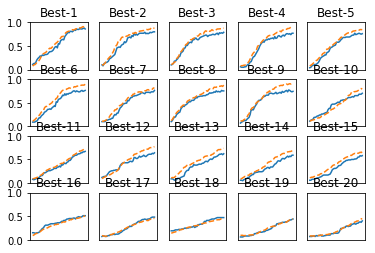

In [10]:
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
import matplotlib.pyplot as plt
from src.mnist import load_mnist
from src.multi_layer_net import MultiLayerNet
from src.util import shuffle_dataset
from src.trainer import Trainer

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 高速化のため訓練データの削減
x_train = x_train[:500]
t_train = t_train[:500]

# 検証データの分離
validation_rate = 0.20
validation_num = x_train.shape[0] * validation_rate
x_train, t_train = shuffle_dataset(x_train, t_train)
x_val = x_train[:int(validation_num)]
t_val = t_train[:int(validation_num)]
x_train = x_train[int(validation_num):]
t_train = t_train[int(validation_num):]


def __train(lr, weight_decay, epocs=50):
    network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100],
                            output_size=10, weight_decay_lambda=weight_decay)
    trainer = Trainer(network, x_train, t_train, x_val, t_val,
                      epochs=epocs, mini_batch_size=100,
                      optimizer='sgd', optimizer_param={'lr': lr}, verbose=False)
    trainer.train()

    return trainer.test_acc_list, trainer.train_acc_list


# ハイパーパラメータのランダム探索======================================
optimization_trial = 100
results_val = {}
results_train = {}
for _ in range(optimization_trial):
    # 探索したハイパーパラメータの範囲を指定===============
    weight_decay = 10 ** np.random.uniform(-8, -4)
    lr = 10 ** np.random.uniform(-6, -2)
    # ================================================

    val_acc_list, train_acc_list = __train(lr, weight_decay)
    print("val acc:" + str(val_acc_list[-1]) + " | lr:" + str(lr) + ", weight decay:" + str(weight_decay))
    key = "lr:" + str(lr) + ", weight decay:" + str(weight_decay)
    results_val[key] = val_acc_list
    results_train[key] = train_acc_list

# グラフの描画========================================================
print("=========== Hyper-Parameter Optimization Result ===========")
graph_draw_num = 20
col_num = 5
row_num = int(np.ceil(graph_draw_num / col_num))
i = 0

for key, val_acc_list in sorted(results_val.items(), key=lambda x:x[1][-1], reverse=True):
    print("Best-" + str(i+1) + "(val acc:" + str(val_acc_list[-1]) + ") | " + key)

    plt.subplot(row_num, col_num, i+1)
    plt.title("Best-" + str(i+1))
    plt.ylim(0.0, 1.0)
    if i % 5: plt.yticks([])
    plt.xticks([])
    x = np.arange(len(val_acc_list))
    plt.plot(x, val_acc_list)
    plt.plot(x, results_train[key], "--")
    i += 1

    if i >= graph_draw_num:
        break

plt.show()

プロットからBest1~5くらいが上手く学習できているように見える。
ハイパーパラメータを確認すると、学習係数が0.001〜0.1くらい、Weight Decay係数が$10^{-8}~10^{-6}$くらいと言うことが分かる。

この範囲内で更に絞込を行ない範囲を狭めてゆく。このように絞込処理を繰り返すことで最終的にパラメータを決定する。
